Exercise 1: Train a classifier to predict the output labels of the given images. The training and validation images with their labels are given as numpy arrays (one row per image) in 5 chunks (see below). The test images (no labels) are given in a test.csv file (also with one row per image). The images are of size (32,32,3). 

- Write a Dataset class and use it for the dataloaders
- Build and train an appropriate NN
- Plot loss values during training and compute model accuracy

## Data uploading

In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torchsummary import summary
import torchvision
import pandas as pd

In [137]:
!wget -O data.zip https://www.dropbox.com/s/bcrs90kyytjph42/cifar-10-batches-py.zip?dl=0
!unzip data.zip

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')
    return dict_

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# data is given in 5 chunks, read into numpy arrays
dict1=unpickle("/content/cifar-10-batches-py/data_batch_1")
dict2=unpickle("/content/cifar-10-batches-py/data_batch_2")
dict3=unpickle("/content/cifar-10-batches-py/data_batch_3")
dict4=unpickle("/content/cifar-10-batches-py/data_batch_4")
dict5=unpickle("/content/cifar-10-batches-py/data_batch_5")

images1, labels1 = dict1[b"data"] , dict1[b"labels"]
images2, labels2 = dict2[b"data"] , dict2[b"labels"]
images3, labels3 = dict3[b"data"] , dict3[b"labels"]
images4, labels4 = dict4[b"data"] , dict4[b"labels"]
images5, labels5 = dict5[b"data"] , dict5[b"labels"]

--2023-01-16 11:44:49--  https://www.dropbox.com/s/bcrs90kyytjph42/cifar-10-batches-py.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/bcrs90kyytjph42/cifar-10-batches-py.zip [following]
--2023-01-16 11:44:49--  https://www.dropbox.com/s/raw/bcrs90kyytjph42/cifar-10-batches-py.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc58bc7eb3c0f9a6083feb1e23d3.dl-eu.dropboxusercontent.com/cd/0/inline/B0rjTn5bY1Ulq-WGd9lbwMTXWood3G5BBy-I5R9jlPWBHVfhFAK4Oiozj3OPxzuxbpcwUVHnQOzfRfs48s7eYI3rSRHYgaaJwWZo3ISB-xonROS5lbVxPT-DXoN08YI_t4LAkZxkEavqdB1n_eX9PxdxzDbT-pdMG2-oq7ARw-rd0A/file# [following]
--2023-01-16 11:44:49--  https://uc58bc7eb3c0f9a6083feb1e23d3.dl-eu.dropboxusercontent.com/cd/0/inline/B0rjTn5bY1Ulq-WGd9lbwMTXWood3G5BBy-I

## Dataset class and dataloaders
##### - Create a dataset class and use it to construct dataloaders for training and validation.
##### - Use one chunck of the data for validation and the rest for training. 
##### - Note: Concatenating numpy arrays can be done via np.concatenate()


In [138]:
from torch.utils.data import Dataset

class CIFAR10(Dataset):
  
  def __init__(self, imagefile, labelsfile):
    super().__init__()
    # df_x= np.concatenate(images1,images2,images3,images4)
    # df_y=np.concatenate(labels1,labels2,labels3,labels4)
    # df_vx=images5
    # df_vy=labels5
    # self.VX=df_vx.iloc[:,:].to_numpy().astype(np.float32).reshape(-1,32,32)
    # self.vy= df_vy.iloc[:,0].to_numpy()
    # self.X= df_x.iloc[:,:].to_numpy().astype(np.float32).reshape(-1,32,32)
    # self.y= df_y.iloc[:,0].to_numpy()

    df_x= imagefile

   
    df_y = labelsfile
     
    # self.X= df_x.astype(np.float32).reshape(-1,32,32)/255.0
    self.X= df_x

    
    self.y= df_y
     
   




  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
    #print(self.X.shape)
    image = self.X[idx]
    image=np.reshape(image,(3,32,32))
    #image = np.transpose(image,(2,0,1))   # HWC -> CHW
    image=image.astype(np.float32)/255.0   
    image = torch.tensor(image)
    
    label= torch.tensor(self.y[idx])
    return image, label



In [173]:
imgfile= np.concatenate((images1,images2,images3,images4))
labelfile= np.concatenate((labels1,labels2,labels3,labels4))

trainset = CIFAR10(imgfile,labelfile )
testset = CIFAR10(images5,labels5 )


#print(trainloader)
batch_size=4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)


validationloader=torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

## Visualize the data
##### Show a few samples of the training dataset


torch.float32


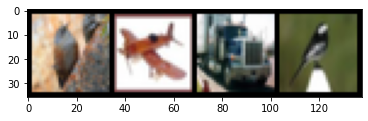

    9     6     3     9


In [157]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    print(img.dtype)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labelfile[labels[j]]:5d}' for j in range(batch_size)))

In [158]:
#print the labels


def unique(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print (x)


unique(labelfile)
print("****")
unique(labels5)



6
9
4
1
2
7
8
3
5
0
****
1
8
5
7
4
3
2
0
9
6


## Network definition

In [159]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
 def __init__(self):
   super(Net,self).__init__()
   self.conv1 = nn.Conv2d(3,6,5)
   self.pool = nn.MaxPool2d(2,2)
   self.bn1 = nn.BatchNorm2d(6)
   self.conv2 = nn.Conv2d(6,16,5)
   #the 16 parameter is the batch size
   self.bn2 = nn.BatchNorm2d(16)
   self.fc1=nn.Linear(16*5*5,120)
   self.fc2=nn.Linear(120,84)
   self.fc3=nn.Linear(84,10)

 def forward(self,x):
   x=self.pool(F.relu(self.bn1(self.conv1(x))))
   x=self.pool(F.relu(self.bn2(self.conv2(x))))
   x=x.view(-1,16*5*5)
   x=F.relu(self.fc1(x))
   x=F.relu(self.fc2(x))
   x=self.fc3(x)
   return x



net = Net()

In [160]:
summary(net, (3, 32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
       BatchNorm2d-2            [-1, 6, 28, 28]              12
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
       BatchNorm2d-5           [-1, 16, 10, 10]              32
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 62,050
Trainable params: 62,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.24
Estimated Total Size (MB): 0.36
---------------------------------------------

## Training
##### Plot loss values during training

[1,  2000] loss: 1.972
[1,  4000] loss: 1.689
[1,  6000] loss: 1.591
[1,  8000] loss: 1.530
[1, 10000] loss: 1.474
[2,  2000] loss: 1.430
[2,  4000] loss: 1.424
[2,  6000] loss: 1.359
[2,  8000] loss: 1.350
[2, 10000] loss: 1.315
[3,  2000] loss: 1.273
[3,  4000] loss: 1.266
[3,  6000] loss: 1.255
[3,  8000] loss: 1.220
[3, 10000] loss: 1.212
[4,  2000] loss: 1.165
[4,  4000] loss: 1.177
[4,  6000] loss: 1.160
[4,  8000] loss: 1.161
[4, 10000] loss: 1.139
[5,  2000] loss: 1.086
[5,  4000] loss: 1.107
[5,  6000] loss: 1.113
[5,  8000] loss: 1.087
[5, 10000] loss: 1.091
[6,  2000] loss: 1.029
[6,  4000] loss: 1.038
[6,  6000] loss: 1.032
[6,  8000] loss: 1.035
[6, 10000] loss: 1.057
[7,  2000] loss: 0.988
[7,  4000] loss: 0.979
[7,  6000] loss: 1.012
[7,  8000] loss: 0.997
[7, 10000] loss: 0.996
[8,  2000] loss: 0.916
[8,  4000] loss: 0.958
[8,  6000] loss: 0.966
[8,  8000] loss: 0.960
[8, 10000] loss: 0.974
Finished Training


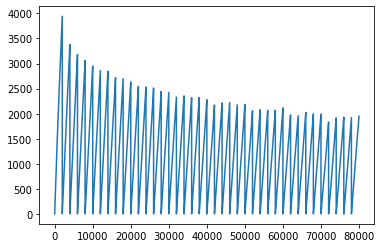

In [161]:
import torch.optim as optim
ls=[]
net.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(8):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
       

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        
        # print statistics
        running_loss += loss.item()
        ls.append(running_loss)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
plt.plot(ls)

## Validation
##### Compute model accuracy


In [162]:
correct = 0
total = 0
net.eval()
# since we're not training, no need to calculate gradients
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        # run images through the network
        outputs = net(images)
        # the class with highest val is the prediction
        predicted = torch.argmax(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 72 %


## Testing
##### Read the test.csv file into a numpy array, and then generate predictions
##### Save the predictions to a file that you will email with your code

In [163]:
# from torch.utils.data import Dataset

# class CIFAR10TEST(Dataset):
  
#   def __init__(self, imagefile):
#     super().__init__()
#     # df_x= np.concatenate(images1,images2,images3,images4)
#     # df_y=np.concatenate(labels1,labels2,labels3,labels4)
#     # df_vx=images5
#     # df_vy=labels5
#     # self.VX=df_vx.iloc[:,:].to_numpy().astype(np.float32).reshape(-1,32,32)
#     # self.vy= df_vy.iloc[:,0].to_numpy()
#     # self.X= df_x.iloc[:,:].to_numpy().astype(np.float32).reshape(-1,32,32)
#     # self.y= df_y.iloc[:,0].to_numpy()

#     df_x= imagefile     
#     # self.X= df_x.astype(np.float32).reshape(-1,32,32)/255.0
#     self.X= df_x

    
   
     
   




#   def __len__(self):
#     return len(self.y)

#   def __getitem__(self,idx):
#     print(self.X.shape)
#     #print(images.dtype)
#     image = self.X[idx]
#     image=np.reshape(image,(3,32,32))
#     #image = np.transpose(image,(2,0,1))   # HWC -> CHW
#     image=image.astype(np.float32)/255.0   
#     image = torch.tensor(image)/255.0 

#     return image

class CIFAR10TEST(Dataset):
    def __init__(self, imagesfile):
        super().__init__()
        df_x = imagesfile
        self.X = df_x.reshape(-1,3,32,32) 

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        image = torch.tensor(image)/255.0
        return image

In [164]:
pd.read_csv("/content/cifar-10-batches-py/test.csv")

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,11,8,7,10,12,10,8,7,8,5,...,115,117,122,124,131,142,144,145,148,139
1,169,167,169,170,170,171,172,172,173,173,...,49,75,104,105,108,105,104,104,102,102
2,94,89,90,84,80,75,65,58,37,40,...,115,113,114,110,104,104,106,104,104,111
3,236,232,231,231,225,221,205,180,195,195,...,199,202,195,166,126,125,133,129,122,118
4,243,236,238,238,238,238,238,238,238,238,...,138,143,142,130,130,139,128,132,144,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,40,35,53,55,44,55,50,46,43,36,...,48,34,55,47,24,16,17,42,46,44
9996,249,247,248,249,250,251,252,251,249,249,...,8,10,11,12,12,14,21,29,42,54
9997,27,26,25,30,41,49,47,54,63,57,...,72,75,69,61,67,64,66,62,55,58
9998,102,105,111,117,120,122,125,126,127,130,...,28,37,42,48,128,160,74,37,39,40


In [168]:
test_data= np.asarray(pd.read_csv("/content/cifar-10-batches-py/test.csv"))

testset = CIFAR10TEST(test_data)
testloader=torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=True)

In [171]:
import csv
csvFile=open('predictions_.csv','a',newline='')
csvWriter=csv.writer(csvFile)

In [172]:
net.eval()
# since we're not training, no need to calculate gradients
with torch.no_grad():
    for data in testloader:
        print(images.dtype)
        images = data
        # run images through the network
        outputs = net(images)
        # the class with highest val is the prediction
        predicted = torch.argmax(outputs.data, 1)
        print(np.array([predicted]))
        csvWriter.writerow(np.array([predicted]))
        
        



torch.float32
[6]
torch.float32
[1]
torch.float32
[5]
torch.float32
[0]
torch.float32
[8]
torch.float32
[6]
torch.float32
[3]
torch.float32
[7]
torch.float32
[6]
torch.float32
[1]
torch.float32
[9]
torch.float32
[5]
torch.float32
[1]
torch.float32
[9]
torch.float32
[5]
torch.float32
[4]
torch.float32
[6]
torch.float32
[7]
torch.float32
[9]
torch.float32
[4]
torch.float32
[1]
torch.float32
[6]
torch.float32
[2]
torch.float32
[8]
torch.float32
[3]
torch.float32
[6]
torch.float32
[9]
torch.float32
[1]
torch.float32
[4]
torch.float32
[1]
torch.float32
[4]
torch.float32
[8]
torch.float32
[6]
torch.float32
[3]
torch.float32
[9]
torch.float32
[1]
torch.float32
[4]
torch.float32
[7]
torch.float32
[1]
torch.float32
[5]
torch.float32
[7]
torch.float32
[9]
torch.float32
[8]
torch.float32
[6]
torch.float32
[4]
torch.float32
[8]
torch.float32
[6]
torch.float32
[1]
torch.float32
[8]
torch.float32
[8]
torch.float32
[0]
torch.float32
[5]
torch.float32
[1]
torch.float32
[0]
torch.float32
[5]
torch.floa

<ipython-input-172-7ec800743d68>:11: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  print(np.array([predicted]))
<ipython-input-172-7ec800743d68>:12: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dty

Streaming output truncated to the last 5000 lines.
torch.float32
[8]
torch.float32
[2]
torch.float32
[5]
torch.float32
[4]
torch.float32
[2]
torch.float32
[1]
torch.float32
[5]
torch.float32
[0]
torch.float32
[4]
torch.float32
[3]
torch.float32
[4]
torch.float32
[0]
torch.float32
[9]
torch.float32
[9]
torch.float32
[5]
torch.float32
[8]
torch.float32
[5]
torch.float32
[5]
torch.float32
[4]
torch.float32
[0]
torch.float32
[1]
torch.float32
[4]
torch.float32
[5]
torch.float32
[8]
torch.float32
[8]
torch.float32
[4]
torch.float32
[0]
torch.float32
[1]
torch.float32
[0]
torch.float32
[2]
torch.float32
[5]
torch.float32
[4]
torch.float32
[3]
torch.float32
[5]
torch.float32
[5]
torch.float32
[4]
torch.float32
[8]
torch.float32
[7]
torch.float32
[9]
torch.float32
[8]
torch.float32
[4]
torch.float32
[4]
torch.float32
[2]
torch.float32
[1]
torch.float32
[7]
torch.float32
[6]
torch.float32
[4]
torch.float32
[3]
torch.float32
[1]
torch.float32
[5]
torch.float32
[4]
torch.float32
[7]
torch.float32